# o4-mini (Azure OpenAI) Financial Sentiment Inference

This notebook evaluates the `o4-mini` model deployed via **Azure OpenAI** as a zero-shot sentiment classifier.

We provide system instructions and a sample sentence, and expect one of: `positive`, `neutral`, or `negative`.

**Objective:** Understand how a general LLM performs on specialized financial sentiment tasks.


In [ ]:
import os
import sys

from dotenv import load_dotenv

sys.path.append("../scripts")

import pandas as pd
from metrics import per_source_metrics
from openai import AzureOpenAI
from plot_utils import plot_confusion_matrix
from sklearn.metrics import classification_report

## Load Validation Data

We'll use the same `val.csv` used in other experiments.


In [ ]:
val_df = pd.read_csv("../data/processed/val.csv")

print("Validation samples:", len(val_df), "\n")
print(val_df["label"].value_counts())

Validation samples: 1788 

label
neutral     1070
positive     444
negative     274
Name: count, dtype: int64


## Azure OpenAI Configuration

Make sure your API key and endpoint are securely loaded.


In [ ]:
load_dotenv(dotenv_path=os.path.join("..", ".env"))

endpoint = os.environ.get("AZURE_ENDPOINT")
model_name = "o4-mini"
deployment = os.getenv("AZURE_DEPLOYMENT")
api_key = os.getenv("AZURE_API_KEY")
api_version = os.getenv("AZURE_API_VERSION")

client = AzureOpenAI(
    api_version=api_version,
    azure_endpoint=endpoint,
    api_key=api_key,
)

## Inference

We provide a sentence and prompt the LLM to classify it as `positive`, `neutral`, or `negative`.


In [ ]:
prompts = [
    {
        "role": "system",
        "content": "You are a financial sentiment classifier. Respond with one word: neutral, positive, or negative.",
    }
]

sentences = val_df["sentence"].tolist()
true_labels = val_df["label"].tolist()

preds = []

for i, sentence in enumerate(sentences):
    response = client.chat.completions.create(
        messages=prompts
        + [
            {
                "role": "user",
                "content": f"Classify the sentiment of this sentence: {sentence}",
            }
        ],
        max_completion_tokens=10000,
        model=deployment,
    )
    result = response.choices[0].message.content.strip().lower()
    preds.append(result)

    print(f"{i}\no4-mini: {result}\nvalidation: {true_labels[i]}\n")

Streaming output truncated to the last 5000 lines.
538
o4-mini: neutral
validation: neutral

539
o4-mini: positive
validation: neutral

540
o4-mini: negative
validation: positive

541
o4-mini: negative
validation: neutral

542
o4-mini: positive
validation: positive

543
o4-mini: neutral
validation: neutral

544
o4-mini: negative
validation: negative

545
o4-mini: neutral
validation: neutral

546
o4-mini: neutral
validation: neutral

547
o4-mini: neutral
validation: neutral

548
o4-mini: negative
validation: negative

549
o4-mini: neutral
validation: neutral

550
o4-mini: neutral
validation: neutral

551
o4-mini: neutral
validation: neutral

552
o4-mini: positive
validation: neutral

553
o4-mini: neutral
validation: positive

554
o4-mini: neutral
validation: neutral

555
o4-mini: positive
validation: neutral

556
o4-mini: positive
validation: neutral

557
o4-mini: neutral
validation: neutral

558
o4-mini: neutral
validation: neutral

559
o4-mini: positive
validation: positive

560
o4-mi

## Evaluation


In [ ]:
report = classification_report(true_labels, preds)
print(report)

              precision    recall  f1-score   support

    negative       0.61      0.91      0.73       274
     neutral       0.91      0.70      0.79      1070
    positive       0.68      0.85      0.76       444

    accuracy                           0.77      1788
   macro avg       0.73      0.82      0.76      1788
weighted avg       0.80      0.77      0.77      1788



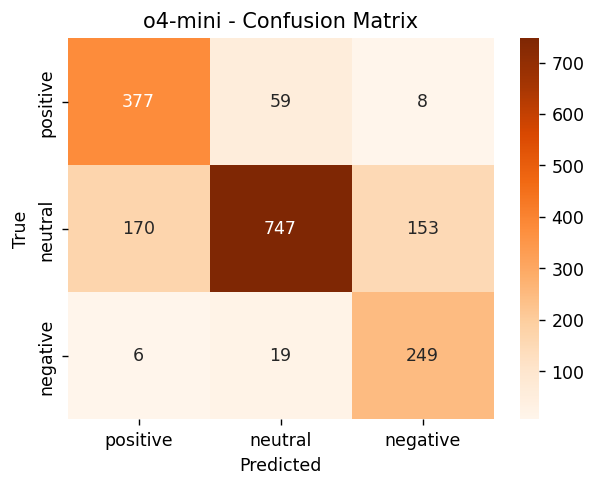

In [ ]:
plot_confusion_matrix(
    true_labels,
    preds,
    labels=["positive", "neutral", "negative"],
    title="o4-mini - Confusion Matrix",
    cmap="Oranges",
)

In [29]:
o4_results = per_source_metrics(true_labels, preds, val_df["source"])
print("o4-mini Per-Source Performance:\n")
for source, acc, f1 in o4_results:
    print(f"{source}: Accuracy={acc:.3f}, Macro-F1={f1:.3f}")

o4-mini Per-Source Performance:

FPB: Accuracy=0.871, Macro-F1=0.865
Twitter: Accuracy=0.728, Macro-F1=0.714
FiQA: Accuracy=0.748, Macro-F1=0.654
